# Modeling

This code refers to the final modeling process, this code is divided into 6 steps:<br>
1 - Import from Libraries<br>
2 - Base Definition Test and Training<br>
3 - Feature Selection<br>
4 - Feature Engineering - Binning (Categorizing)<br>
5 - Logistic Regression and Scorecard Generation<br>
6 - Validation of the Models<br>

## 1 - Import of Libraries

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from optbinning import Scorecard, BinningProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix

## 2 - Base Definition Test and Training

In [86]:
# Read Data Frame
df_model = pd.read_csv(r'Files/DF_COSTUMERS.csv',index_col='USER_ID',encoding='latin1')

df_model['PRODUCT_ID'] = df_model['PRODUCT_ID'].astype('Int64').astype(str)
df_model['PRODUCT_ID'].replace('<NA>',np.nan,inplace=True)

D:\Program Files\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [88]:
# Split data 80/20 keeping the distribution of defaulters in the test set equal to the distribution before the split
X = df_model.drop('VT', axis = 1)
y = df_model['VT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)


# Safety Backup 
X_train, X_test = X_train.copy(), X_test.copy() 

## 3 - Feature Selection

Technique seeks to find the most appropriate variables for the model. Technique applies the Chi-Squared test for categorical variables and the ANOVA F-statistic test for numeric variables

Categorical Features

In [89]:
# List with categorical features
X_train_cat = X_train.select_dtypes(include = ['object','category']).copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

# Dictionary for storing chi-squared test results
chi2_check = {}

# loop between the columns of the training set to calculate the chi-statistic test on the target variable (y_train)
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))
    
# Convert dictionary to Data Frame
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

chi2_result

,Feature,p-value
0,MARITAL_STATUS,0.000000
1,PROFESSION,0.000000
2,CITY,0.000000
3,HIRING_CHANNEL,0.000000
4,PAYMENT_METHOD,0.000000
5,PRODUCT_ID,0.000000
6,ENTRY_DATE,0.000000
7,CEP_3,0.000000
8,COMMERCIAL_CLASS,0.000041
9,GENDER,0.875336


In [90]:
# Saving features to be used (p-value at 5% significance)
top_cat_features = chi2_result[chi2_result['p-value']<=0.05]['Feature'].to_list()

Applying to numeric features

In [91]:
# Function f_classif does not support Missing Values, in raw input will be performed
X_train_num.fillna(X_train_num.mean(), inplace = True)

# F-Statistic calculation and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)

# Convert to Data Frame
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,
                                     'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,AGE,2024.135183,0.0
1,TIME_CLIENT,1026.700465,0.0
2,PRODUCT_PRICE,900.243224,0.0


In [92]:
# Saving features to be used (p-value at 5% significance)
top_num_features = ANOVA_F_table[ANOVA_F_table['p values']<=0.05]['Numerical_Feature'].to_list()

Updating test and training sets based on the above checks

In [93]:
# Updating test and training sets
X_train= X_train.loc[:,top_cat_features+top_num_features]
X_test = X_test.loc[:,top_cat_features+top_num_features]

## 4 - Feature Engineering - Binning

Creating the builder to group categorical bases based on their distribution in the base

In [94]:
# List with all base features (except vt)
list_features = X_train.columns.values
list_categorical = X_train_cat.columns.values

# Criteria for selection of groups (bins)
selection_criteria = {'iv':{'min':.005, 'max':.5, 'strategy':'highest'}}

# Constructor for the BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_features,
    selection_criteria= selection_criteria
    ,fixed_variables=['AGE','MARITAL_STATUS', 'PROFESSION', 'CITY',
       'HIRING_CHANNEL', 'PAYMENT_METHOD', 'PRODUCT_ID', 'PRODUCT_PRICE',
       'COMMERCIAL_CLASS', 'TIME_CLIENT'])

## 5 - Logistic Regression and Scorecard

In [95]:
# Applying Logistic Regression
logreg = LogisticRegression(C=1, max_iter=1000, random_state=None)

Creating the Scorecard constructor and carrying out Fitting (modeling application)

In [96]:
# Defining methods for scale and their respective values
scaling_method = 'min_max'
scaling_method_data = {'min':0,'max':1000}

# Constructor and fit 
scorecard = Scorecard(
    binning_process=binning_process,
    estimator=logreg,
    scaling_method=scaling_method,
    scaling_method_params=scaling_method_data,
    intercept_based=True) #,reverse_scorecard=False)


# Scorecard
scorecard.fit(X_train,y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=array(['GENDER', 'MARITAL_STATUS', 'PROFESSION', 'CITY', 'HIRING_CHANNEL',
       'PAYMENT_METHOD', 'PRODUCT_ID', 'SEGMENT_TYPE', 'COMMERCIAL_CLASS',
       'ENTRY_DATE', 'CEP_3'], dtype=object),
                                         fixed_variables=['AGE',
                                                          'MARITAL_STATUS',
                                                          'PROFESSION', 'CITY',
                                                          'HIRING_CHANNEL',
                                                          'PAYMENT_METHOD',
                                                          'PRODUCT_ID',
                                                          'PRODUCT_P...
                                                                    'strategy': 'highest'}},
                                         variable_names=array(['MARITAL_STATUS', 'PROFESSION', 'CITY', 'HIRING_CHANNEL',
       'PA

In [97]:
# Generation of  Scorecard
scorecard_summary = scorecard.table(style="detailed").round(3)
scorecard_summary.to_excel('scorecard_table_detailed.xlsx', index=False)

pd.set_option('display.max_rows', 100)
scorecard_summary

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,MARITAL_STATUS,0,"[SEPARATED, OTHER, MARRIED, DIVORCED]",45453,0.252,42694,2759,0.061,0.542,0.060,0.007,0.441,0.000
1,MARITAL_STATUS,1,"[SINGLE, COMMON LAW MARRIAGE, NOT INFORMED]",11538,0.064,10576,962,0.083,0.200,0.002,0.000,0.441,6.731
2,MARITAL_STATUS,2,[WIDOW(ER)],11008,0.061,8246,2762,0.251,-1.103,0.113,0.013,0.441,32.398
3,MARITAL_STATUS,3,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,0.441,10.672
4,MARITAL_STATUS,4,Missing,112025,0.622,100505,11520,0.103,-0.031,0.001,0.000,0.441,11.284
0,PROFESSION,0,"[GRANEJRIO, MILITAR APOSETA, MILITARES DO EXER...",29721,0.165,28802,919,0.031,1.248,0.158,0.019,-0.498,51.204
1,PROFESSION,1,"[ESTHETICIAN, HOME MAKER / HUSBAND, RURAL, BAK...",11439,0.064,10808,631,0.055,0.644,0.020,0.003,-0.498,37.786
2,PROFESSION,2,"[PSYCHOLOGIST, SALES ASSISTANT, GARDENER, CARE...",12481,0.069,11140,1341,0.107,-0.080,0.000,0.000,-0.498,21.717
3,PROFESSION,3,"[AGRONOMIST, PROFESSIONAL, DELIVERY PERSON, AS...",38163,0.212,28910,9253,0.242,-1.058,0.355,0.042,-0.498,0.000
4,PROFESSION,4,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.498,23.495


The information contained in the Scorecard provides details related to the calculation of the score for each user, and it includes the following information:

* Variable: Name of the variable
* Bin: Group containing its respective elements
* Count: Total number of observations in the group
* Non-Event: Total number of non-defaulting customers in the group
* Event: Total number of defaulting customers in the group
* Event Rate: Ratio of defaulting customers to the total group (Bad Rate)
* WoE, IV, JS: Indicators of group relevance for modeling
* Coefficient: Estimated parameters for probability calculation
* Points: Final associated score for each group to be considered for calculation.

To calculate the score, the sum of the scores of each customer variable is made. Next, an estimation of the score of a sample of customers from the test set is performed (set considered only to verify the performance of the modeling)

In [98]:
# Calculating the score in the test base
X_test['score'] = scorecard.score(X_test)
X_test['y_predict'] = scorecard.predict(X_test)

X_test.sample(n=5)

,MARITAL_STATUS,PROFESSION,CITY,HIRING_CHANNEL,PAYMENT_METHOD,PRODUCT_ID,ENTRY_DATE,CEP_3,COMMERCIAL_CLASS,AGE,TIME_CLIENT,PRODUCT_PRICE,score,y_predict
USER_ID,,,,,,,,,,,,,,
86463,NaN,SELF-EMPLOYED,SÃO ROQUE,MIGRATION,PAYMENT SLIP,37923,2021-01-09,13990,RESIDENTIAL,35.0,2.4,89.9,151.845922,0
84320,NaN,NaN,POUSO ALEGRE,MIGRATION,PAYMENT SLIP,53280,2021-01-04,37412,RESIDENTIAL,43.0,2.4,69.9,292.805878,0
122514,NaN,NaN,ARARAS,OTHER - NOT USED,PAYMENT SLIP,4965,2021-05-01,13731,RESIDENTIAL,72.0,2.1,99.9,270.288808,0
161952,MARRIED,TEACHER,SÃO ROQUE,MIGRATION,PAYMENT SLIP,37910,2021-12-20,13990,RESIDENTIAL,51.0,1.5,139.9,284.046780,0
59622,NaN,NaN,BELÉM,MIGRATION,PAYMENT SLIP,4246,2020-11-01,60713,RESIDENTIAL,23.0,2.6,74.9,219.560246,0


## 6 - Model Validation

Validation of models using the Kolmogorov-Smirnov curve and the ROC curve.

KS Curve:<br>
The Kolmogorov-Smirnov (KS) metric quantifies the distance between the curves of two cumulative probability functions. KS takes values between 0 and 100% and is defined as the maximum distance between these curves. This metric is used to measure how well the model separates the classes of the response variable (0 or 1, good or bad, yes or no).

ROC Curve:<br>
The Area Under the Curve (AUC) is a metric that measures how well the model separates the classes of the response variable based on its cumulative distribution. Larger values are better.

In [99]:
from optbinning.scorecard.plots import plot_ks, plot_auc_roc

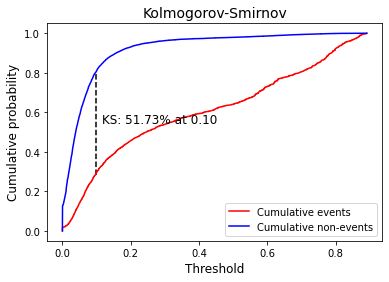

In [100]:
# Kolmogorov_Smirnov Plot
plot_ks(y_test,scorecard.predict_proba(X_test)[:,1])

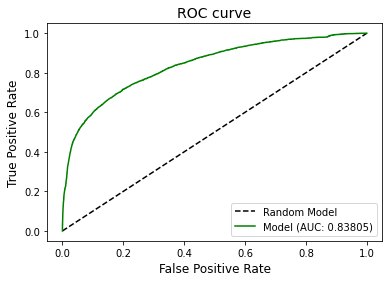

In [101]:
# ROC-AUC plot
plot_auc_roc(y_test,scorecard.predict_proba(X_test)[:,1])

In [102]:
pd.DataFrame(classification_report(y_test,X_test.y_predict,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.932193,0.657178,0.917167,0.794685,0.904689
recall,0.979188,0.359031,0.917167,0.669110,0.917167
f1-score,0.955112,0.464368,0.917167,0.709740,0.906034
support,40505.000000,4501.000000,0.917167,45006.000000,45006.000000
